# Image Classification Using CIFAR-10 Dataset: A Comparison of Manhattan (L1) and Eucledian (L2) Distances With 5-Fold Cross-Validation

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

np.random.seed(1337)

# Dataset and Preprocessing

In [135]:
import kagglehub

dataset_path = kagglehub.dataset_download("ashishsaxena2209/animal-image-datasetdog-cat-and-panda")

dirs = ['cats', 'dogs', 'panda']

X = []
y = []

img_size = (32, 32)

for dir in dirs:
    dir_path = os.path.join(dataset_path, 'animals', dir)
    paths = os.listdir(dir_path)

    rand_idxs = np.arange(len(paths))
    np.random.shuffle(rand_idxs)
    rand_idxs = rand_idxs[0:200]  
    
    for idx in rand_idxs:
        full_path = os.path.join(dir_path, paths[idx])
        img = cv2.imread(full_path, 0)
        resized_img = cv2.resize(img, img_size)
        X.append(resized_img)
        y.append(dir)

X = np.array(X)
y = np.array(y)

In [136]:
print(f'shape of X: {X.shape}, shape of y: {y.shape}')

shape of X: (600, 32, 32), shape of y: (600,)


# Model Building and Evaluation

To classify the gray-scale images, we will employ the k-nearest neighbors (k-NN) algorithm. This algorithm classifies an image by 
considering the class labels of its k nearest neighbors. We will use two distance metrics, Manhattan (L1) and Euclidean (L2), to measure 
the similarity between images. 

To evaluate the performance of our model, we will use 5-fold cross-validation. The training dataset will be divided into 5 subsets (folds), 
and the model will be trained and evaluated 5 times using different combinations of training and validation data. This approach allows 
us to assess the model's performance across multiple folds, providing a more robust evaluation. 

## Distance functions

Manhattan (L1) distance: 
$$
D_{\text{L1}}(\mathbf{x}, \mathbf{y}) = \sum_{i=1}^{n} |x_i - y_i|
$$

Euclidean (L2) distance:
$$
D_{\text{L2}}(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$


In [137]:
def L1(x, y):
    return np.sum(np.abs(x - y))

def L2(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

## k-Fold KNN

We define the KNN model as a function with parameters `target, X, K and distance_function`. Here  `target` is the image to be tested, `X` is the array data points that are available, `K` is the number of neighbors to be considered while selecting class label for the test image and `distance_function` is the function to be used. 


In [138]:
def KNN(target, X, K, distance_function):
    distances = []            
    for idx_train in train:
        distances.append(
            (idx_train, distance_function(target, X[idx_train]))
        )
        
    distances.sort(key=lambda item: item[1])
    
    neighbours = distances[:K]
    top_labels = [y[n[0]] for n in neighbours]
    
    label = h_frequency(top_labels)
    confidence = top_labels.count(label) / K

    return (label, confidence)

For each fold, we will vary the hyperparameter K (the number of nearest neighbors) and record the accuracy achieved by the model for 
each value of K. We will compute the average accuracy across all folds for each value of K and distance calculation technique. 

We are going to use `K = 5` and scale it in each iteration by multiplying with the iteration index `i`. At the same time, we’ll perform `5-fold` cross-validation using `n_splits = 5`, which helps us evaluate the model more reliably by splitting the dataset into 5 parts and rotating the test set.

During each fold, we will collect the predictions and record the top 5 predictions with the highest confidence scores that are also correct. This helps us focus on the model’s most certain and accurate outputs.

In [139]:
from sklearn.model_selection import KFold
from collections import Counter

def h_frequency(lst):
    c = Counter(lst)
    return c.most_common(1)[0][0]

K = 5
n_splits = 5
kfold = KFold(n_splits, shuffle=True)
distance_functions = ['L1', 'L2']
history = {f: {} for f in distance_functions}
N = 5
top_N = []

for i, (train, test) in enumerate(kfold.split(X)):
    for f in distance_functions:
        total_correct = 0
        for idx_test in test:
            label, confidence = KNN(X[idx_test], X, K*(i+1), globals()[f])
        
            if label == y[idx_test]:
                total_correct += 1
                top_N.append((idx_test, confidence))
                top_N = sorted(top_N, reverse=True, key=lambda item: item[1])[:N]            
        
        history[f][K*(i+1)] = total_correct / len(test)

In [140]:
print('history:', history)
print(f'top-{N}:', top_N)

history: {'L1': {5: 0.5166666666666667, 10: 0.48333333333333334, 15: 0.425, 20: 0.5166666666666667, 25: 0.4}, 'L2': {5: 0.45, 10: 0.4166666666666667, 15: 0.39166666666666666, 20: 0.49166666666666664, 25: 0.48333333333333334}}
top-5: [(411, 1.0), (73, 1.0), (369, 1.0), (554, 1.0), (526, 0.9)]


## Plot history

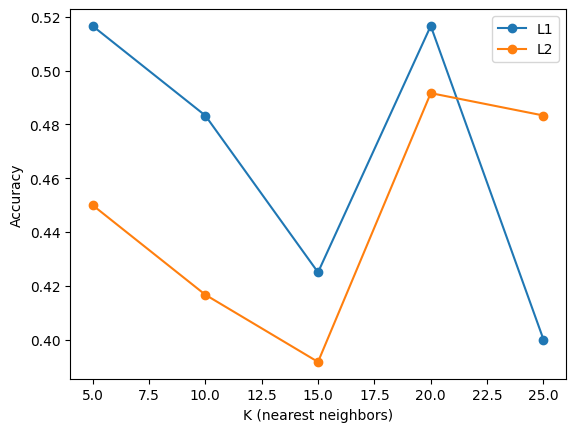

In [141]:
for f in distance_functions:
    plt.plot(history[f].keys(), history[f].values(), marker='o', label=f)
    plt.xlabel('K (nearest neighbors)')
    plt.ylabel('Accuracy')
    plt.legend()

# Discussion

Looking at the results, we can see that the Manhattan (`L1`) distance generally performed better than the Euclidean (`L2`) distance. The highest accuracy for `L1` reached about `51.7%` at `k=5` and `k=20`, while `L2`’s best performance was around `49.2%` at `k=20`. This suggests that `L1` might be more effective for this specific subset of the dataset, possibly because `L1` is less sensitive to small variations or outliers in pixel intensities, which is important when working with image data that might be noisy or have subtle differences between classes. The grayscale images, being fairly low resolution (`32x32`), might also benefit from `L1`'s ability to capture distinct differences in pixel values without being influenced too much by less important variations.

Additionally, the `top-5` results showed very strong predictions for individual classes, particularly for `panda`, which could indicate that the model is better at identifying certain features, such as shape or texture, that are more distinct in some categories. However, the overall accuracy remains somewhat moderate, which could be due to the relatively small dataset size (only `100` images per class). This limits the model’s ability to learn more complex patterns. To improve accuracy, we could consider increasing the dataset size, using more advanced image processing techniques like feature extraction, or exploring other distance metrics that might better capture the nuances of image data.


# Top 5 Predictions

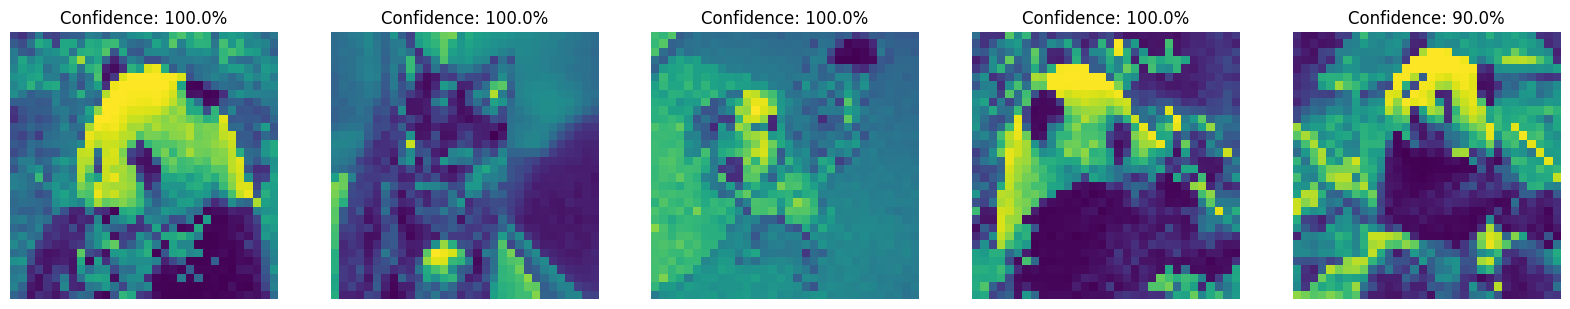

In [142]:
plt.figure(figsize=(20,N))
for i, t in enumerate(top_N):
    plt.subplot(1, N, i+1)
    plt.imshow(X[t[0]])
    plt.axis('off')
    plt.title(f'Confidence: {t[1]*100}%')